<a href="https://colab.research.google.com/github/Suhani2716/Wireless/blob/main/Collected_CSI_Values_tested_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch torchvision torchaudio


In [3]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [4]:
def load_csi_file(path):
    df = pd.read_csv(path, header=None, delim_whitespace=True, engine="python")
    df = df[0].str.split(",", expand=True)
    df = df.replace("", np.nan).astype(float).fillna(0)
    return df.values


In [5]:
def load_dataset(base_path):
    X = []
    y = []

    for label, cls in enumerate(["class_0", "class_1"]):
        files = glob.glob(f"{base_path}/{cls}/*.csv")
        for f in files:
            arr = load_csi_file(f)
            X.append(arr)
            y.append(label)

    return X, np.array(y)


In [6]:
def pad_sequences(arr_list):
    max_len = max(a.shape[0] for a in arr_list)
    max_feat = max(a.shape[1] for a in arr_list)

    padded = []
    for a in arr_list:
        pad = np.zeros((max_len, max_feat))
        pad[:a.shape[0], :a.shape[1]] = a
        padded.append(pad)

    return np.stack(padded)


In [7]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float().unsqueeze(1)   # (batch, 1, H, W)
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [8]:
import zipfile

zip_path = "/content/raw_csi.zip"
extract_path = "/content/raw_csi"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extracted to:", extract_path)



Extracted to: /content/raw_csi


In [9]:
base = "/content/raw_csi/raw_csi"   # ← change if needed

X_raw, y = load_dataset(base)
X = pad_sequences(X_raw)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_ds = CSIDataset(X_train, y_train)
val_ds   = CSIDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)



/tmp/ipython-input-185797379.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, header=None, delim_whitespace=True, engine="python")
/tmp/ipython-input-185797379.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("", np.nan).astype(float).fillna(0)
/tmp/ipython-input-185797379.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, header=None, delim_whitespace=True, engine="python")
/tmp/ipython-input-185797379.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fu

In [10]:
class ResNetCSI(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.model(x)


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNetCSI().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [12]:
for epoch in range(10):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            predicted = preds.argmax(dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}: Train Loss={total_loss:.3f}, Val Acc={acc:.3f}")


Epoch 1: Train Loss=3.920, Val Acc=0.500
Epoch 2: Train Loss=5.818, Val Acc=0.500
Epoch 3: Train Loss=0.225, Val Acc=0.500
Epoch 4: Train Loss=2.639, Val Acc=0.625
Epoch 5: Train Loss=3.355, Val Acc=1.000
Epoch 6: Train Loss=2.107, Val Acc=1.000
Epoch 7: Train Loss=0.451, Val Acc=0.875
Epoch 8: Train Loss=2.903, Val Acc=1.000
Epoch 9: Train Loss=0.453, Val Acc=0.875
Epoch 10: Train Loss=0.235, Val Acc=0.625


In [13]:
def predict(model, array):
    model.eval()
    x = torch.tensor(array).float().unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(x).argmax(dim=1).item()
    return "Person Present" if pred == 1 else "No Person"


Random Testing

In [14]:
import random

def random_test(model, X_raw, y, n=5):
    model.eval()
    print("🔍 Randomized Testing:")

    for i in range(n):
        idx = random.randint(0, len(X_raw)-1)

        true_label = "Person Present" if y[idx] == 1 else "No Person"
        padded = pad_sequences([X_raw[idx]])[0]
        pred = predict(model, padded)

        print(f"Sample {idx}: True = {true_label},  Predicted = {pred}")


In [15]:
random_test(model, X_raw, y, n=10)


🔍 Randomized Testing:
Sample 26: True = Person Present,  Predicted = Person Present
Sample 31: True = Person Present,  Predicted = Person Present
Sample 18: True = No Person,  Predicted = No Person
Sample 19: True = No Person,  Predicted = No Person
Sample 18: True = No Person,  Predicted = No Person
Sample 14: True = No Person,  Predicted = Person Present
Sample 26: True = Person Present,  Predicted = Person Present
Sample 34: True = Person Present,  Predicted = Person Present
Sample 10: True = No Person,  Predicted = No Person
Sample 21: True = Person Present,  Predicted = Person Present


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_csi_heatmap(arr, title="CSI Heatmap"):
    plt.figure(figsize=(10,6))
    plt.imshow(arr, aspect="auto")
    plt.colorbar(label="Amplitude")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Time Index")
    plt.title(title)
    plt.show()


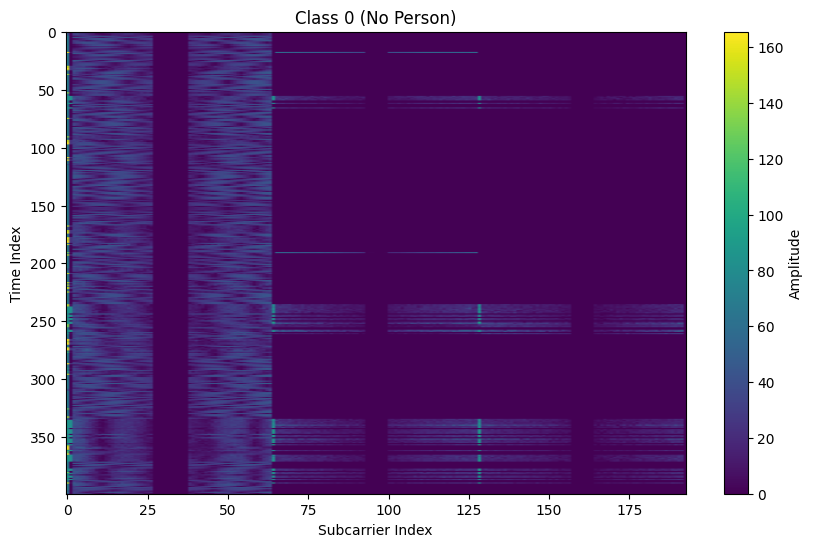

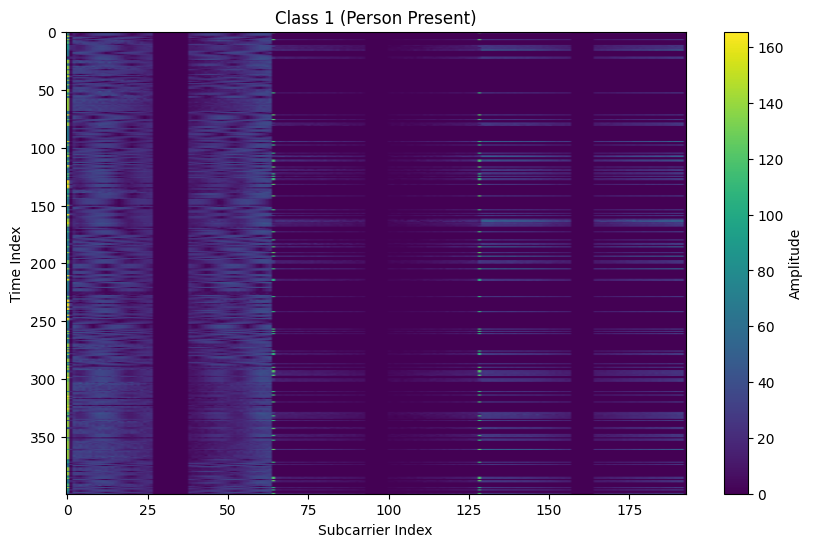

In [17]:
plot_csi_heatmap(X_raw[0], "Class 0 (No Person)")
plot_csi_heatmap(X_raw[-1], "Class 1 (Person Present)")


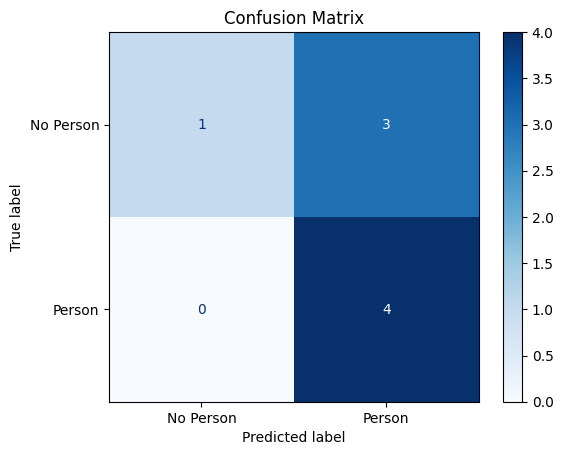

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(model, loader):
    all_preds = []
    all_true = []

    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(yb.cpu().numpy())

    cm = confusion_matrix(all_true, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Person","Person"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
plot_conf_matrix(model, val_loader)


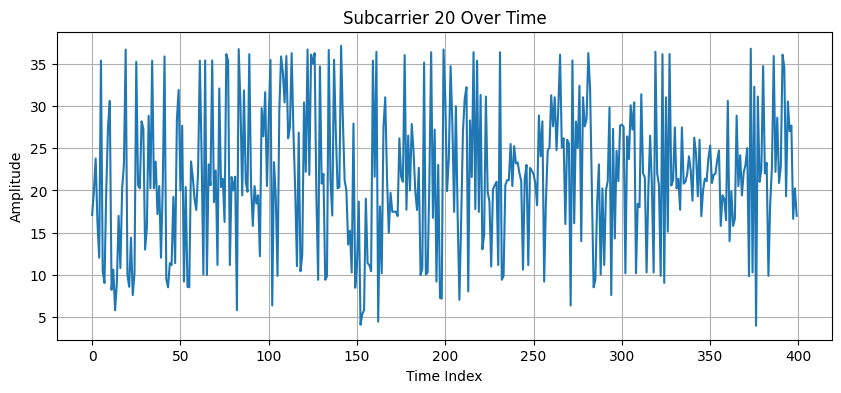

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subcarrier(arr, sub=30):
    plt.figure(figsize=(10,4))
    plt.plot(arr[:, sub])
    plt.title(f"Subcarrier {sub} Over Time")
    plt.xlabel("Time Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
plot_subcarrier(X_raw[0], sub=20)


In [20]:
import matplotlib.pyplot as plt

def plot_class_timeseries_separately(X_raw, y, subcarrier=20):
    # Find example indices
    idx0 = next(i for i, label in enumerate(y) if label == 0)
    idx1 = next(i for i, label in enumerate(y) if label == 1)

    arr0 = X_raw[idx0]
    arr1 = X_raw[idx1]

    # --- Plot Class 0 ---
    plt.figure(figsize=(12,4))
    plt.plot(arr0[:, subcarrier], color='blue')
    plt.title(f"Class 0 (No Person) – Subcarrier {subcarrier}")
    plt.xlabel("Time Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # --- Plot Class 1 ---
    plt.figure(figsize=(12,4))
    plt.plot(arr1[:, subcarrier], color='orange')
    plt.title(f"Class 1 (Person Present) – Subcarrier {subcarrier}")
    plt.xlabel("Time Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


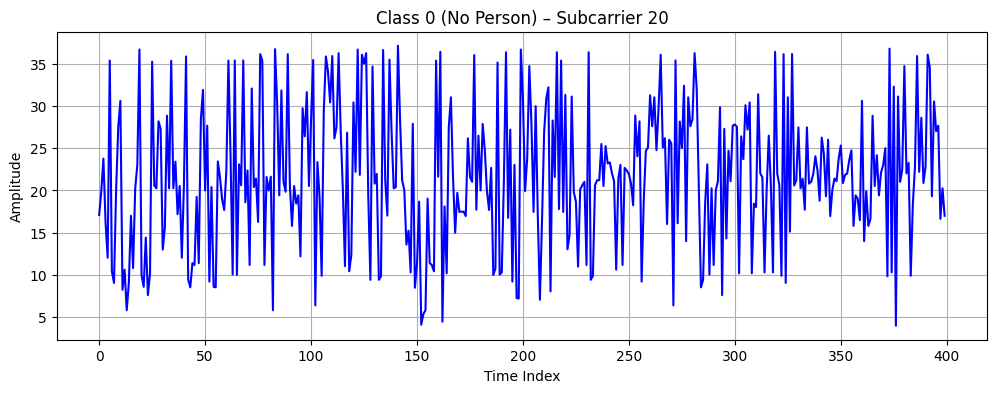

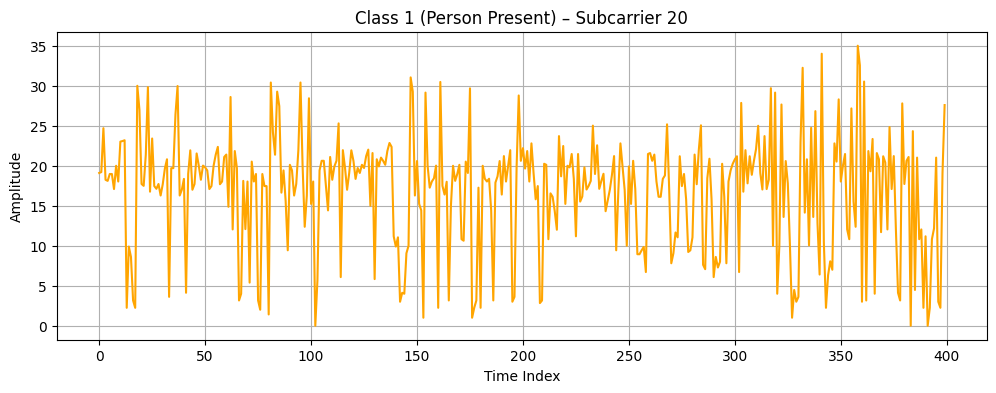

In [21]:
plot_class_timeseries_separately(X_raw, y, subcarrier=20)



In [22]:
import matplotlib.pyplot as plt
import numpy as np

def smooth(x, w=7):
    return np.convolve(x, np.ones(w)/w, mode='same')

def optimize_plot_class_timeseries(X_raw, y, subcarrier=20):
    # Find first examples
    idx0 = next(i for i, label in enumerate(y) if label == 0)
    idx1 = next(i for i, label in enumerate(y) if label == 1)

    arr0 = X_raw[idx0][:, subcarrier]
    arr1 = X_raw[idx1][:, subcarrier]

    # Normalize both signals (optional but makes comparison fair)
    def norm_signal(s):
        return (s - np.min(s)) / (np.max(s) - np.min(s) + 1e-6)

    arr0_n = norm_signal(arr0)
    arr1_n = norm_signal(arr1)

    arr0_s = smooth(arr0_n, 9)
    arr1_s = smooth(arr1_n, 9)

    # --- Plot Class 0 ---
    plt.figure(figsize=(14,4), dpi=150)
    plt.plot(arr0_n, color='skyblue', alpha=0.4, label="Raw")
    plt.plot(arr0_s, color='blue', linewidth=2, label="Smoothed")
    plt.fill_between(range(len(arr0_n)),
                     arr0_s - np.std(arr0_n),
                     arr0_s + np.std(arr0_n),
                     color='blue', alpha=0.1, label="Stability band")
    plt.title(f"Class 0 (No Person) – Subcarrier {subcarrier}", fontsize=14)
    plt.xlabel("Time Index")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # --- Plot Class 1 ---
    plt.figure(figsize=(14,4), dpi=150)
    plt.plot(arr1_n, color='orange', alpha=0.4, label="Raw")
    plt.plot(arr1_s, color='red', linewidth=2, label="Smoothed")
    plt.fill_between(range(len(arr1_n)),
                     arr1_s - np.std(arr1_n),
                     arr1_s + np.std(arr1_n),
                     color='red', alpha=0.1, label="Stability band")
    plt.title(f"Class 1 (Person Present) – Subcarrier {subcarrier}", fontsize=14)
    plt.xlabel("Time Index")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


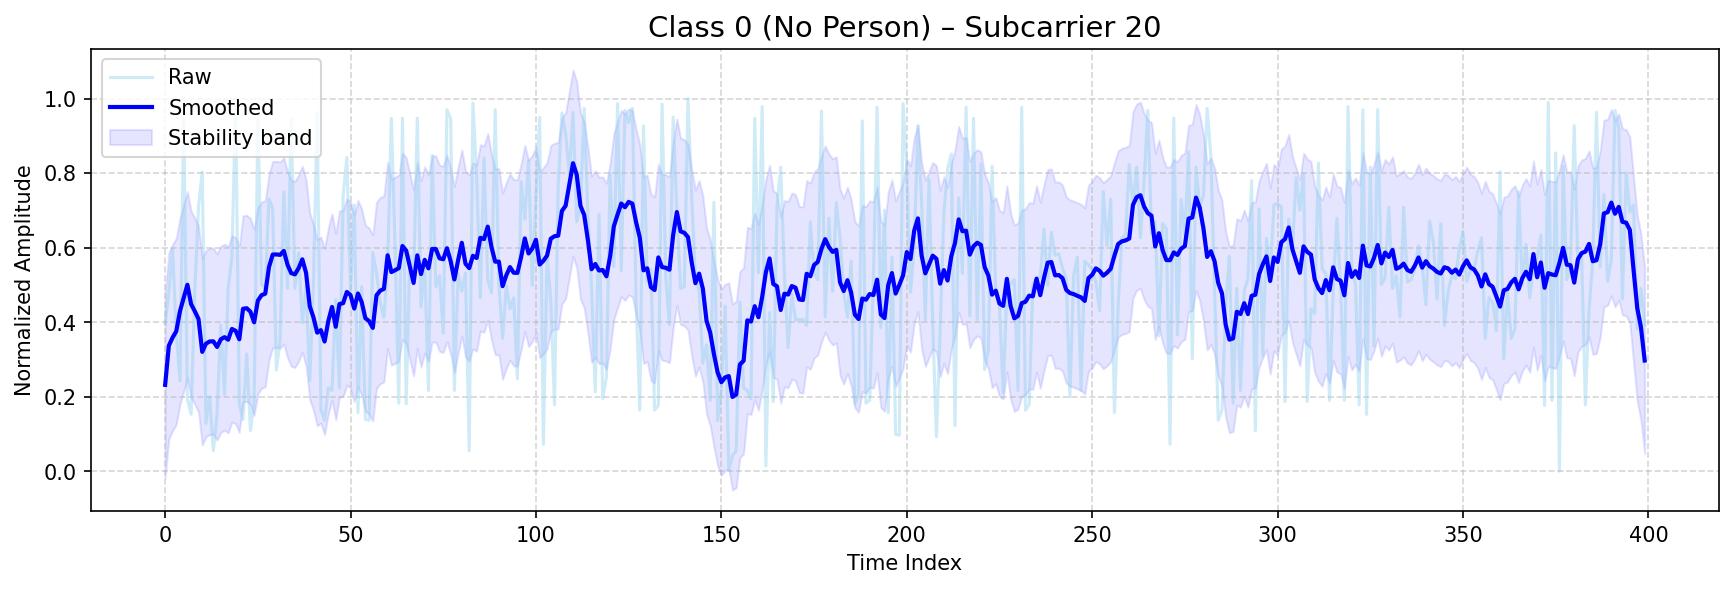

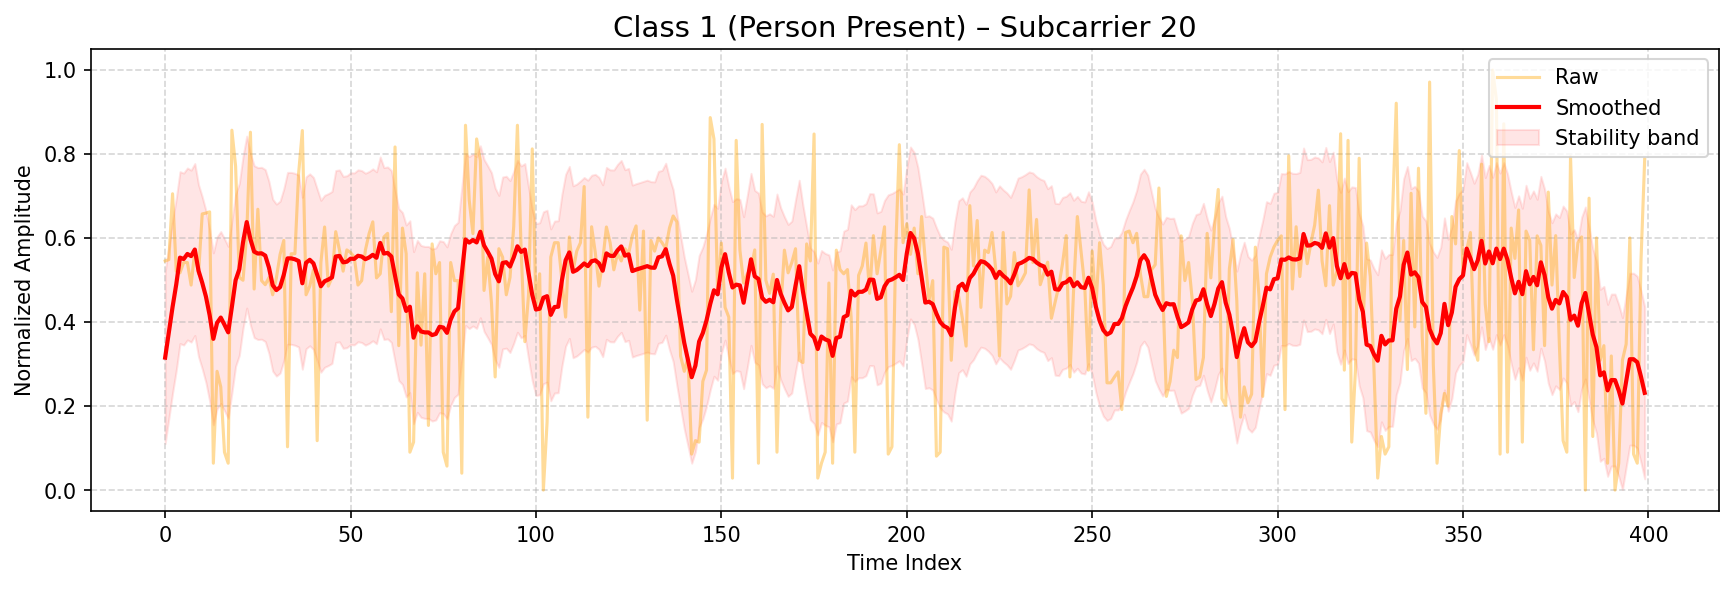

In [23]:
optimize_plot_class_timeseries(X_raw, y, subcarrier=20)
